## L-inf Norm attacks against FMNIST

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

import sys, os, gc, math
import tensorflow as tf
import numpy as np
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc
from scipy.fftpack import dct,idct


sys.path.append('../')
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from models.neural_network import NeuralNetwork
from models.cnn import CNN
from models.util import *


#Seed used for choosing classes, training points, and test points.
#SEED = 14
SEED=11

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Define params of model
input_shape = (28,28,1)
num_classes = 10

# Load/Create Network and Generate Adversarial Data

In [3]:
#%%capture one
#Load model from disk
model_name = 'FASHION-MNIST-L0'
model_save_path = '../trained_models/' + model_name + '-model.json'
weights_save_path = '../trained_models/' + model_name + 'weights'
model = CNN(model_name=model_name, dataset='fashion_mnist', transform='dct',seed=SEED, project=False)
print ('Total Model Params: %d' % model.num_params)
model.load_model(model_save_path, weights_save_path) 
epochs = 20
#model.train(epochs=epochs)
#model.save_model(model_save_path, weights_save_path)     

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Total Model Params: 1199882
Loaded model from disk


In [4]:
#Model Accuracy
print ('Model Accuracy: %.5f' % (model.model.evaluate(model.val_data, model.val_labels)[1]))

10000/10000 [==============================] - 2s 158us/step
Model Accuracy: 0.99140


In [4]:
%%capture two
#Get training samples
num_train_samples = 1000
data_indices = model.gen_rand_indices(low=int(model.train_data.shape[0]/2), high=model.train_data.shape[0], seed=SEED, num_samples=num_train_samples)
train_data = model.train_data[data_indices]
train_data_labels = model.train_labels[data_indices]
train_data_labels_int = np.argmax(train_data_labels, axis=1)

**GREYBOX ATTACKS**

In [5]:
%%capture three
num_test_samples_per_class = 100
num_test_samples = num_classes*num_test_samples_per_class

#Generate test points
test_indices = model.gen_rand_indices_all_classes(y=model.test_labels, seed=SEED, num_samples=num_test_samples_per_class)

In [10]:
%%capture four
import time
#Get Regular, JSMA, DF, and CW test points
reg_data = model.test_data[test_indices]
start_time = time.time()
fgsm_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='FGSM')
print("--- JSMA: %s seconds ---" % (time.time() - start_time))
start_time = time.time()
bim_data = model.generate_perturbed_data(model.test_data[test_indices], seed=SEED, perturbation='BIM')
print("--- CW: %s seconds ---" % (time.time() - start_time))

In [6]:
%%capture five
reg_data = np.load('data/reg_data_fmnist_li.npy')
fgsm_data = np.load('data/fgsm_data_fmnist_li.npy')
bim_data = np.load('data/bim_data_fmnist_li.npy')


In [106]:
#%%capture five
#np.save('data/reg_data_fmnist_li', reg_data)
#np.save('data/fgsm_data_fmnist_li', fgsm_data)
#np.save('data/bim_data_fmnist_li', bim_data)

In [7]:
print ('Model Accuracy REG: %.5f' % (model.model.evaluate(reg_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy FGSM: %.5f' % (model.model.evaluate(fgsm_data,model.test_labels[test_indices])[1]))
print ('Model Accuracy BIM: %.5f' % (model.model.evaluate(bim_data,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 4s 4ms/step
Model Accuracy REG: 0.91800
1000/1000 [==============================] - 0s 212us/step
Model Accuracy FGSM: 0.22700
1000/1000 [==============================] - 0s 206us/step
Model Accuracy BIM: 0.05300


Training Data: 


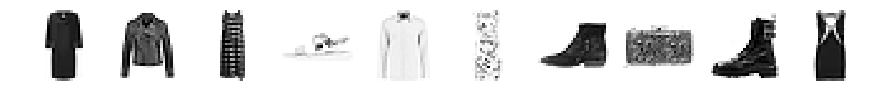

In [8]:
#Lets visualize training data
x_vis = np.random.choice(range(0,num_train_samples), 10)
print ('Training Data: ')
visualize(train_data[x_vis].reshape(-1,*input_shape), 10, '../figures/train-mnist_linf')

In [50]:
x_vis = np.array([550, 636, 277, 435, 740, 762, 665, 572, 332, 985])

Regular: 


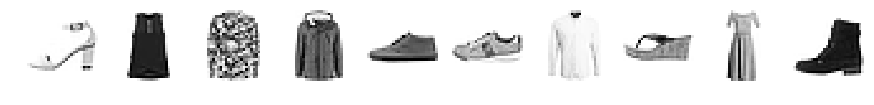

FGSM: 


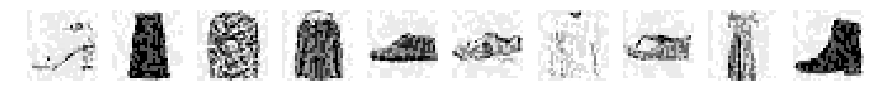

BIM: 


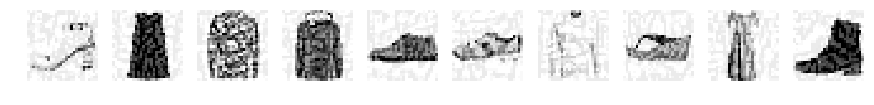

In [51]:
#Lets visualize samples from each attack
#x_vis = np.random.choice(range(0,num_test_samples), 10)
print ('Regular: ')
visualize(reg_data[x_vis].reshape(-1,*input_shape), 10, '../figures/reg-fmnist_li')
print ('FGSM: ')
visualize(fgsm_data[x_vis].reshape(-1,*input_shape), 10, '../figures/fgsm-fmnist_li')
print ('BIM: ')
visualize(bim_data[x_vis].reshape(-1,*input_shape), 10, '../figures/bim-fmnist_li')

In [31]:
x_vis

array([523, 294, 284, 892, 829, 652, 584, 746, 668, 978])

In [10]:
%%capture seven
#Get predictions
reg_preds = model.model.predict(reg_data.reshape(-1,*input_shape))
fgsm_preds = model.model.predict(fgsm_data.reshape(-1,*input_shape))
bim_preds = model.model.predict(bim_data.reshape(-1,*input_shape))

#Convert preds to labels
reg_labels = preds_to_labels(reg_preds)
fgsm_labels = preds_to_labels(fgsm_preds)
bim_labels = preds_to_labels(bim_preds)

#Select Adversarial Points (i.e. points that lead to misclassification)
true_preds = np.argmax(model.test_labels[test_indices], axis=1)

#Check which points are actually adversarial and select those
fgsm_idx = np.where(np.argmax(fgsm_preds, axis=1) != true_preds)[0]
bim_idx = np.where(np.argmax(bim_preds, axis=1) != true_preds)[0]


#Filter data points to be used for similarity
fgsm_data_fil = fgsm_data[fgsm_idx]
bim_data_fil = bim_data[bim_idx]


#Filter labels to be used
fgsm_labels_fil = fgsm_labels[fgsm_idx]
bim_labels_fil = bim_labels[bim_idx]

In [11]:
def avg_linf_dist(orig, adv):
    """Get the mean l2 distortion between two orig and adv images"""
    linf_dist = 0.0
    num_ = orig.shape[0]
    if num_ > 0:
        for i in range(orig.shape[0]):
            linf_dist+= np.linalg.norm(orig[i].flatten() - adv[i].flatten(),ord=np.inf)
        return linf_dist/orig.shape[0]
    else:
        return np.nan

In [12]:
#Get l-inf distortion 
print ('FGSM: %.5f' % (avg_linf_dist(reg_data[fgsm_idx], fgsm_data_fil)))
print ('BIM: %.5f' % (avg_linf_dist(reg_data[bim_idx], bim_data_fil)))

FGSM: 0.15000
BIM: 0.15000


## DANTZIG Reconstruction

In [13]:
D = get_matrix(28*28)

In [14]:
import cvxpy as cp
from multiprocessing import Pool

In [15]:
def dantzig(y, D, n=784, eta=6):
    x = cp.Variable(n)
    b = cp.Variable(n)
    obj = cp.Minimize(cp.norm(x,1))
    c = np.zeros((n))
    constraints = [cp.SOC(c.T*x + eta, D*x - y)]
    constraints = [ b <= x, -b <= x, D.T*(y - D*b) <= eta, -D.T*(y - D*b) <=eta, (y-D*b)<=0.16, (D*b-y) <=0.16]
    prob = cp.Problem(obj, constraints)

    print("Optimal value", prob.solve(solver='ECOS'))
    return b.value
    

In [40]:
args =[] 

In [41]:
def clean_sample(a):
    x_hat = dantzig(a,D.T, n=28*28)
    x_hat_top = get_topk_vec(x_hat,k=40)
    recon = idct(x_hat_top.flatten(),norm='ortho').reshape(28,28)
    return recon

In [42]:
for i in range(num_test_samples):
    args.append(bim_data[i].flatten())

In [ ]:
%%capture pooling1
p = Pool(5)
clean = p.map(clean_sample, args)
p.terminate()

In [ ]:
#Created with very small eta only and k=40
clean_bim = np.zeros(bim_data.shape)
for i in range(num_test_samples):
    clean_bim[i,:,:,0] = clean[i]

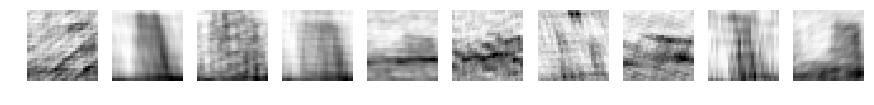

In [54]:
visualize(clean_bim[x_vis].reshape(-1,*input_shape), 10, '../figures/bim-clean-fmnist_li')

In [27]:
np.save('data/clean_fmnist_bim_li', clean_bim)

In [28]:
print ('Model Accuracy Reconstructed BIM: %.5f' % (model.model.evaluate(clean_bim,model.test_labels[test_indices])[1]))

1000/1000 [==============================] - 0s 189us/step
Model Accuracy Reconstructed BIM: 0.57500
